In [44]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import cv2
import skimage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

In [45]:
# Read images
AIA193_2016 = sunpy.map.Map("data/aia_193A/2016*.fits")
AIA193_2016_matrix = np.array(list(d.data for d in AIA193_2016))


# Normalize images
min_values = AIA193_2016_matrix.min(axis=2).min(axis=1)
max_values = AIA193_2016_matrix.max(axis=2).max(axis=1)

rg = max_values - min_values
rg = np.maximum(rg, 1e-4*np.ones(rg.shape)).reshape([-1,1,1])

AIA193_2016_mnorm = (AIA193_2016_matrix-min_values.reshape([-1,1,1])) / rg


# Discretize images to detect faulty data
AIA193_2016_bytes = np.round(AIA193_2016_mnorm*255).astype(np.uint8)


# Calculate histograms
nbins = 10
hist_vectors = np.array([np.histogram(i.flatten(), bins=np.linspace(0,256,nbins))[0] for i in AIA193_2016_bytes])


# Cluster histograms
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(hist_vectors/hist_vectors.max())

class1 = AIA193_2016_bytes[kmeans.labels_ == 0, :, :]
class2 = AIA193_2016_bytes[kmeans.labels_ != 0, :, :]

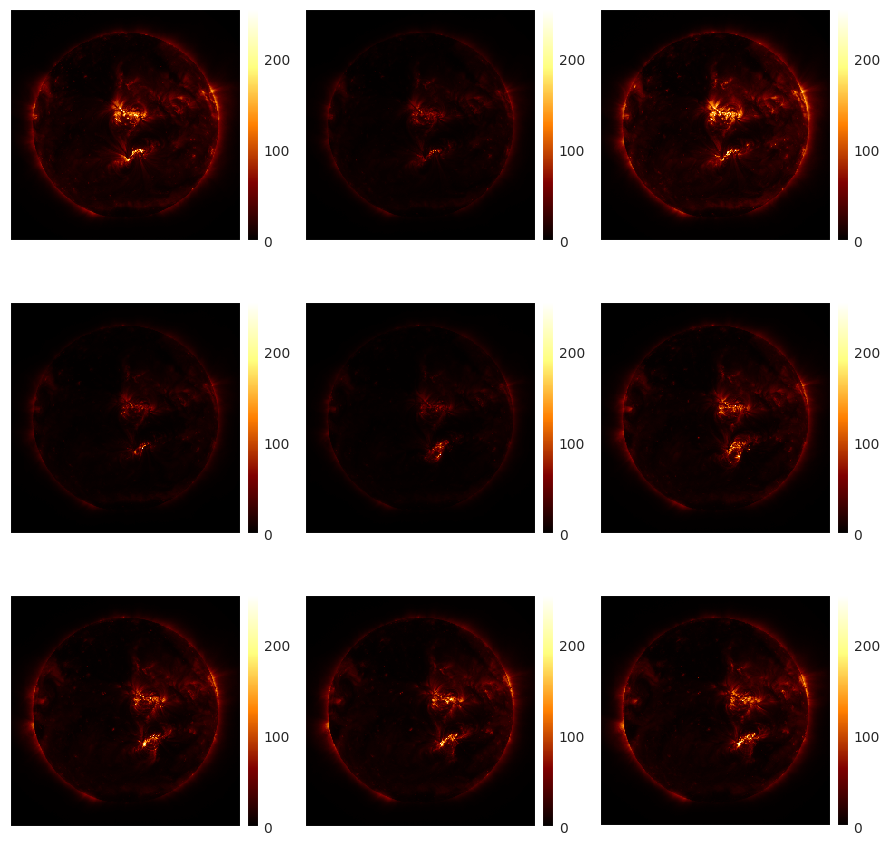

In [46]:
isns.ImageGrid([i for i in class1[:9]], cmap="afmhot") # class2 is (probably) noise 

In [47]:
clean_input = AIA193_2016_mnorm[kmeans.labels_ == 0, :, :]

In [48]:
input_img = keras.Input(shape=[256,256,1])
code_size = 16

# lrelu = layers.LeakyReLU(0.2)
optim = keras.optimizers.Adam(0.001)
# optim = keras.optimizers.SGD(0.001)
loss = "mse"


#x = layers.Reshape([256,256,1])(input_img)
x = input_img
x = layers.Conv2D(8, 3, activation="relu", padding='same', strides=1)(x)
x = layers.Conv2D(8, 3, activation="relu", padding='same', strides=1)(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(16, 3, activation="relu", padding='same', strides=1)(x)
x = layers.Conv2D(16, 3, activation="relu", padding='same', strides=1)(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(32, 3, activation="relu", padding='same', strides=1)(x)
x = layers.Conv2D(32, 3, activation="relu", padding='same', strides=1)(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.1)(x)
encoded = layers.Dense(code_size, activation="sigmoid")(x)

x = layers.Dense(256, activation="relu")(encoded)

x = layers.Reshape([8, 8, 4])(x)
x = layers.UpSampling2D()(x)

x = layers.Conv2D(64, 3, activation="relu", padding='same', strides=1)(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", padding='same', strides=2)(x)

x = layers.Conv2D(32, 3, activation="relu", padding='same', strides=1)(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding='same', strides=2)(x)

x = layers.Conv2D(16, 3, activation="relu", padding='same', strides=1)(x)
x = layers.Conv2DTranspose(6, 3, activation="relu", padding='same', strides=2)(x)

x = layers.Conv2D(16, 3, activation="relu", padding='same', strides=1)(x)
x = layers.Conv2DTranspose(1, 3, activation="relu", padding='same', strides=2)(x)

#decoded = layers.Reshape([256,256])(x)
decoded = x


encoder = keras.Model(input_img, encoded)
decoder = keras.Model(encoded, decoded)
print(encoder.summary())
decoder.summary()


autoencoder = keras.Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss=loss, optimizer=optim, metrics=["mae"])
autoencoder.summary()

Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_151 (Conv2D)         (None, 256, 256, 8)       80        
                                                                 
 conv2d_152 (Conv2D)         (None, 256, 256, 8)       584       
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_153 (Conv2D)         (None, 128, 128, 16)      1168      
                                                                 
 conv2d_154 (Conv2D)         (None, 128, 128, 16)      2320      
                                                          

In [49]:
n_epochs = 100
batch_size = 128

print(clean_input.shape)
autoencoder.fit(clean_input.reshape([-1, 256,256,1]), clean_input.reshape([-1, 256,256,1]), epochs=n_epochs, batch_size=128)

(2475, 256, 256)
Epoch 1/100
 1/20 [>.............................] - ETA: 1:40 - loss: 0.0031 - mae: 0.0309

KeyboardInterrupt: 

1/1 [==============================] - 0s 27ms/step


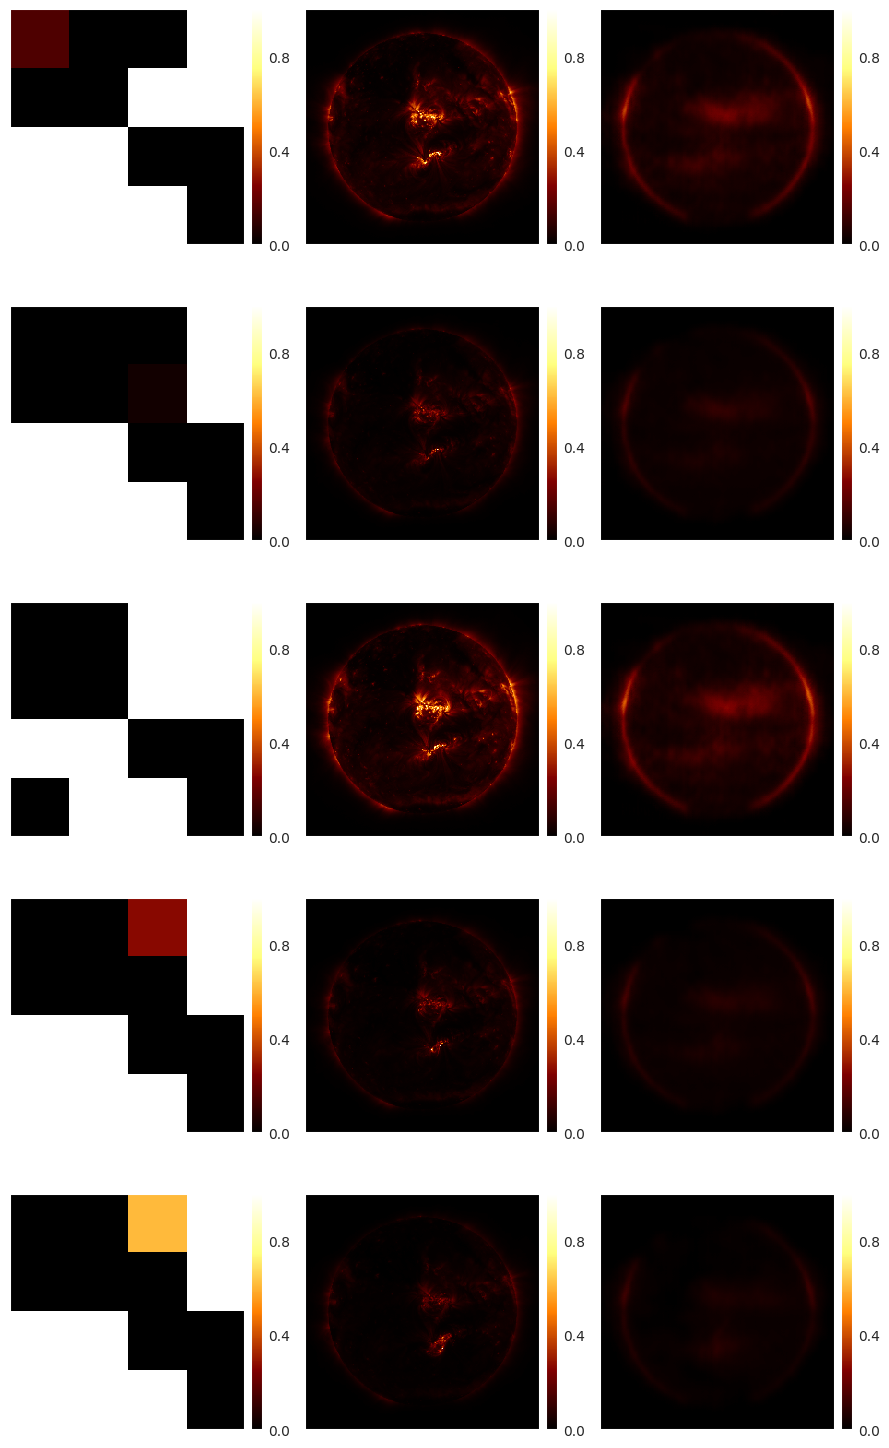

In [ ]:
example = clean_input[0:5, :, :]
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, example, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.reshape(i[0], [4,4]))
    images.append(np.squeeze(i[1]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap="afmhot", vmin=0, vmax=1)